In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import phase_ucb_acq1, generate1, log_likelihood, get_likelihood_utility

 /Users/brianmontambault/anaconda/envs/gp-rl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

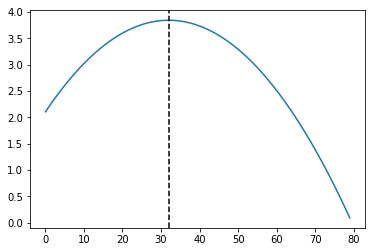

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [5]:
steepness_params = np.array([0, 100])
x_midpoint_params = np.array([10, 20])
yscale_params = np.array([0, 1])
temp_params = np.array([.01, .01])
trials = np.arange(20)
titles = ['Pure Exploit', 'Pure Explore']

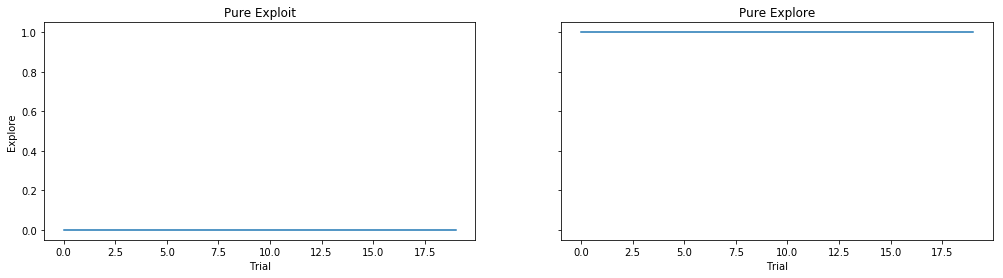

In [6]:
explore = (1 - 1. / (1 + yscale_params[:,None] * np.exp(-steepness_params[:,None] * (trials - x_midpoint_params[:,None]))))
fig, axes = plt.subplots(1, len(steepness_params), sharex=True, sharey=True, figsize=(17, 4))
for i in range(len(axes)):
    axes[i].plot(explore[i])
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel('Explore')
    axes[i].set_xlabel('Trial')

In [7]:
true_params = {'steepness': steepness_params, 'x_midpoint': x_midpoint_params,
                                  'temperature': temp_params, 'yscale': yscale_params}

In [8]:
data = generate1(phase_ucb_acq1, true_params, neg_quad_kern, neg_quad, 10, 20, 2, np.array([.5, .5]))

In [9]:
actions = data[:,5,:].argmax(axis=1)

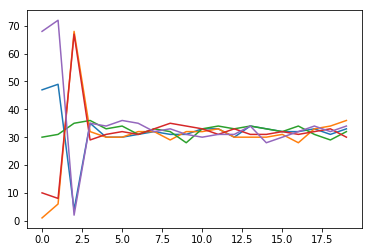

In [10]:
plt.plot(actions[:5].T);

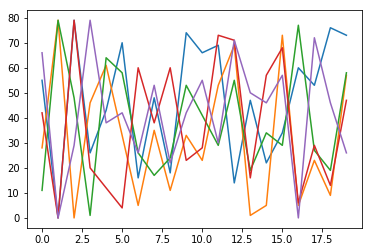

In [11]:
plt.plot(actions[5:].T);

## No Mixture

In [12]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    no_mix_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:27<00:00, 54.81draws/s] 
The acceptance probability does not match the target. It is 0.6791827709103219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6745784097391386, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


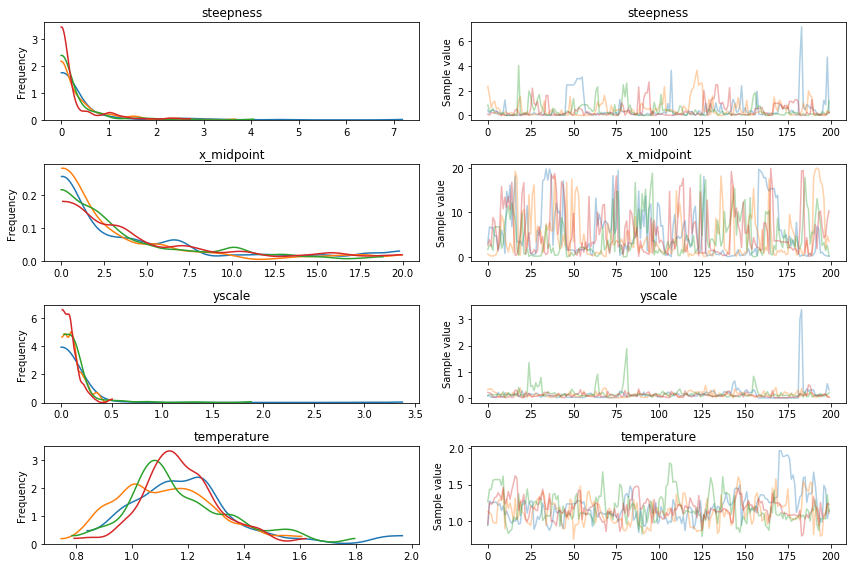

In [13]:
pm.traceplot(no_mix_trace);

## Fixed Mixture

In [14]:
k=2
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=k)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=k)
    yscale = pm.Gamma('yscale', 1., 1., shape=k)
    temperature = pm.Gamma('temperature', .1, .1, shape=k)
    param_mixture = pm.Dirichlet('param_mixture', a=np.ones(k))

    obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, k, param_mixture))
    fixed_mix_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param_mixture, temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [01:01<00:00, 16.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


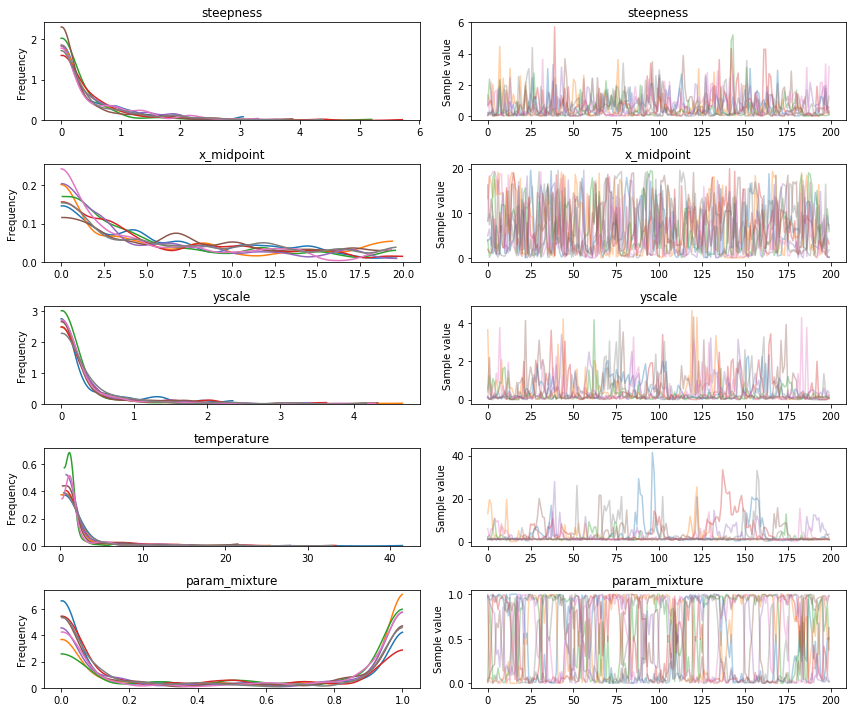

In [15]:
pm.traceplot(fixed_mix_trace);

In [22]:
a = data[:,5,:,:]
l, u = get_likelihood_utility(data, phase_ucb_acq1, true_params, 2, np.array([.5, .5]))
action_likelihood = l.transpose(1,3,0,2) * a[:,:,:,None]
c = np.log(action_likelihood.sum(axis=1)).sum(axis=1)
print (c)

[[  -40.21205834           -inf]
 [  -43.51017003           -inf]
 [  -44.5138941            -inf]
 [  -39.17183123           -inf]
 [  -43.28449217           -inf]
 [-2168.53503036   -77.32901109]
 [-1729.61380349   -79.16285275]
 [-1535.03988505   -79.29042477]
 [-1747.73946032   -77.77396419]
 [-1602.83732436   -78.7485414 ]]


In [25]:
(c * np.array([.5, .5])).sum()

-inf

In [17]:
samples = np.array(fixed_mix_trace)

In [18]:
samples[-1]

{'param_mixture': array([0.97689934, 0.02310066]),
 'param_mixture_stickbreaking__': array([3.74452243]),
 'steepness': array([3.16891484, 1.27028165]),
 'steepness_log__': array([1.15338921, 0.23923865]),
 'temperature': array([0.93323897, 2.06213191]),
 'temperature_log__': array([-0.06909398,  0.72374036]),
 'x_midpoint': array([0.21872223, 1.79612277]),
 'x_midpoint_interval__': array([-4.50468866, -2.31600428]),
 'yscale': array([0.24882593, 0.10102474]),
 'yscale_log__': array([-1.39100172, -2.29238987])}

In [19]:
last_sample_params = {p:v for p,v in samples[-1].items() if p in true_params}

In [20]:
last_sample_params

{'steepness': array([3.16891484, 1.27028165]),
 'temperature': array([0.93323897, 2.06213191]),
 'x_midpoint': array([0.21872223, 1.79612277]),
 'yscale': array([0.24882593, 0.10102474])}

In [23]:
l1, u1 = get_likelihood_utility(data, phase_ucb_acq1, last_sample_params, 2, samples[-1]['param_mixture'])
action_likelihood1 = l1.transpose(1,3,0,2) * a[:,:,:,None]
c1 = np.log(action_likelihood1.sum(axis=1)).sum(axis=1)
print (c1)

[[-75.27483251 -81.20394993]
 [-75.16220484 -81.92675483]
 [-77.04330504 -82.38048285]
 [-75.14925403 -81.62575861]
 [-74.92702048 -81.26530505]
 [-98.14128467 -89.88262668]
 [-92.46871375 -87.23357605]
 [-90.32117207 -86.02780949]
 [-93.49855652 -88.09167499]
 [-92.13380129 -87.07043371]]


In [26]:
(c1 * samples[-1]['param_mixture']).sum()

-844.17993493866